# Toyota Yaris II -  price prediction


In [76]:
import pandas as pd
import numpy as np
import sqlite3

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def get_view_data():
    sql_query = """SELECT * FROM v_cars"""
    conn = sqlite3.connect("pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

def get_data():
    sql_query ="""
SELECT 
    all_offers.offer_id,otomoto_all.s_date, otomoto_all.e_date, all_offers.private_business, all_offers.region,
    all_offers.city, all_offers.model, all_offers.year, all_offers.mileage, all_offers.engine_capacity, all_offers.vin,
    all_offers.fuel_type, all_offers.engine_power, all_offers.gearbox, all_offers.transmission, all_offers.door_count,
    all_offers.nr_seats, all_offers.color, all_offers.features,otomoto_all.price, all_offers.price_raw, all_offers.currency, 
    all_offers.country_origin, all_offers.registration
FROM 
    otomoto_all, all_offers
WHERE 
    otomoto_all.uid = all_offers.uid; 
"""

    conn = sqlite3.connect("pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

#%time df = get_data() #~13 ms
%time df = get_view_data() #~13 ms

#%time for i in range(3000): df = get_data()

df.head(3)

Wall time: 104 ms


,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,transmission,door_count,nr_seats,color,features,price,price_raw,currency,country_origin,registration
0,6005738641,2020-04-17,2020-05-01,business,malopolskie,krakow,yaris,2009,111000,1000,...,front-wheel,5,5,grey,0,6200,6200.0,0,f,0
1,6018694885,2020-04-17,2020-05-01,business,warminsko-mazurskie,ostroda,yaris,2008,45706,998,...,0,3,5,white,abs central-lock electronic-immobiliser front-...,4700,4700.0,0,pl,0
2,6025678407,2020-04-17,2020-05-01,business,mazowieckie,milanowek,yaris,2009,174000,1300,...,0,5,5,silver,abs cd central-lock front-electric-windows ele...,19800,19800.0,0,0,0


In [50]:
df.columns

Index(['offer_id', 's_date', 'e_date', 'private_business', 'region', 'city',
       'model', 'year', 'mileage', 'engine_capacity', 'vin', 'fuel_type',
       'engine_power', 'gearbox', 'transmission', 'door_count', 'nr_seats',
       'color', 'features', 'price', 'price_raw', 'currency', 'country_origin',
       'registration'],
      dtype='object')

In [51]:
def optimize_df():
    #df['offer_id'] = df['offer_id'].astype(np.uint32)
    df['offer_id'] = pd.to_numeric (df['offer_id'], downcast='unsigned')
    df['s_date'] = pd.to_datetime(df['s_date']) 
    df['e_date'] = pd.to_datetime(df['e_date']) 
    df['year'] = pd.to_numeric(df['year'], downcast='unsigned')
    df['mileage'] = pd.to_numeric(df['mileage'], downcast='unsigned')
    df['engine_capacity'] = pd.to_numeric(df['engine_capacity'], downcast='unsigned')
    df['engine_power'] = pd.to_numeric(df['engine_power'], downcast='unsigned')
    df['door_count'] = pd.to_numeric(df['door_count'], downcast='unsigned')
    df['nr_seats'] = pd.to_numeric(df['nr_seats'], downcast='unsigned')
    df['price'] = pd.to_numeric(df['price'], downcast='float')
    df['price_raw'] = pd.to_numeric(df['price_raw'], downcast='float')
    
%time optimize_df()    

Wall time: 110 ms


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318 entries, 0 to 317
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   offer_id          318 non-null    uint64        
 1   s_date            318 non-null    datetime64[ns]
 2   e_date            318 non-null    datetime64[ns]
 3   private_business  318 non-null    object        
 4   region            318 non-null    object        
 5   city              318 non-null    object        
 6   model             318 non-null    object        
 7   year              318 non-null    uint16        
 8   mileage           318 non-null    uint32        
 9   engine_capacity   318 non-null    uint16        
 10  vin               318 non-null    object        
 11  fuel_type         318 non-null    object        
 12  engine_power      318 non-null    uint8         
 13  gearbox           318 non-null    object        
 14  transmission      318 non-

In [53]:
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

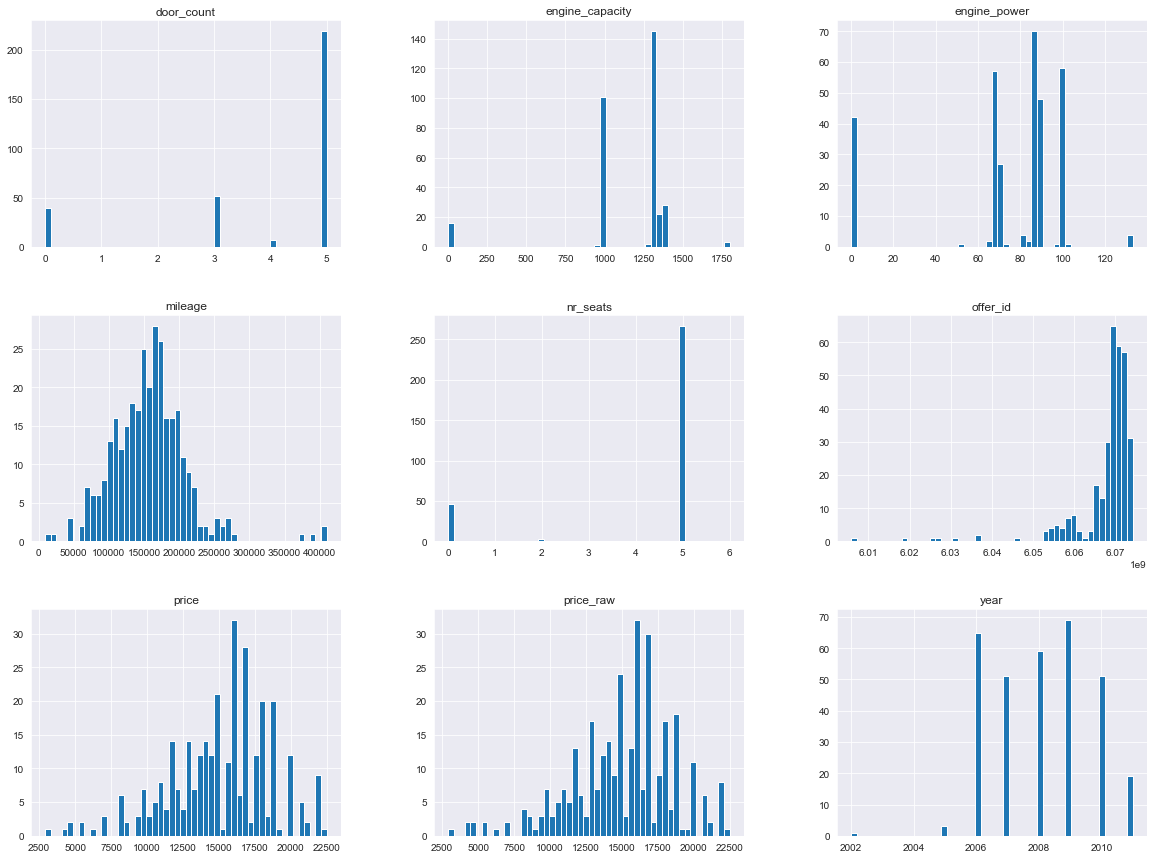

In [54]:
df.hist(bins=50,figsize=(20,15))
plt.show()

## Feature engineering

In [55]:
def general_features():
    df['duration'] = (df['e_date'] - df['s_date']).dt.days.astype(np.uint16)
    df['price_chng'] = (df['price'] - df['price_raw'])
    #df['active'] = df['duration'].apply()
    
%time general_features()

Wall time: 10.9 ms


In [26]:
df.sample(3)

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,nr_seats,color,features,price,price_raw,currency,country_origin,registration,duration,price_chng
236,6071686209,2020-04-17,2020-05-01,private,lodzkie,lodz,yaris,2008,124000,1296,...,5,grey,abs cd central-lock front-electric-windows ele...,16900.0,16900.0,0,pl,0,14,0.0
70,6066936383,2020-04-17,2020-05-01,private,pomorskie,koscierzyna,yaris,2009,213285,1329,...,5,grey,abs cd central-lock front-electric-windows ele...,15999.0,15999.0,0,d,0,14,0.0
143,6069509850,2020-05-01,2020-05-01,private,podkarpackie,rzeszow,yaris,2007,235900,1364,...,0,silver,abs cd central-lock front-electric-windows ele...,11000.0,11000.0,0,0,0,0,0.0


In [56]:
# Price change
df[df['price_chng']!=0].head()

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,nr_seats,color,features,price,price_raw,currency,country_origin,registration,duration,price_chng
12,6054649805,2020-04-20,2020-05-01,private,podlaskie,suwalki,yaris,2007,178560,1300,...,5,silver,abs cd central-lock front-electric-windows ele...,15900.0,16600.000000,0,d,0,11,-700.000000
44,6064542261,2020-04-17,2020-05-01,private,malopolskie,tarnow,yaris,2008,157000,1300,...,0,grey,abs cd central-lock front-electric-windows ele...,21900.0,14999.000000,0,d,0,14,6901.000000
59,6065857762,2020-04-19,2020-05-01,private,lodzkie,sieradz,yaris,2008,270981,998,...,5,silver,abs cd electronic-rearview-mirrors electronic-...,10999.0,11500.000000,0,0,0,12,-501.000000
84,6067672282,2020-04-17,2020-05-01,business,wielkopolskie,ostrzeszow,yaris,2007,410000,998,...,2,silver,abs cd central-lock electronic-immobiliser fro...,5400.0,4390.240234,0,pl,0,14,1009.759766
90,6067981935,2020-04-17,2020-04-28,business,zachodniopomorskie,bialogard,yaris,2006,112000,1298,...,5,black,abs cd central-lock front-electric-windows ele...,14500.0,14900.000000,0,0,0,11,-400.000000


Wall time: 66.7 ms


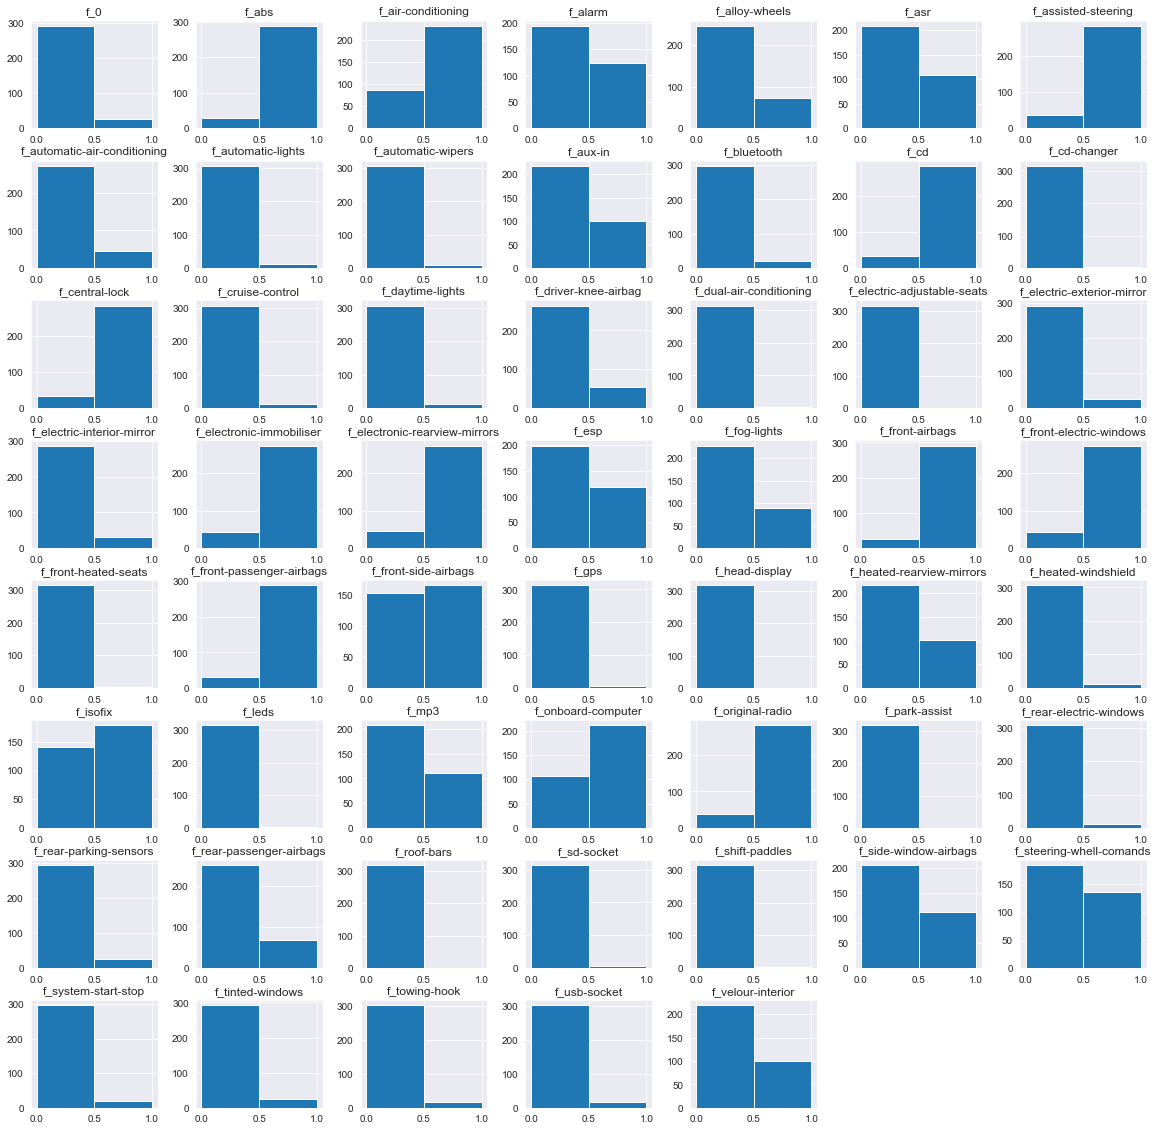

In [57]:
#car features
def benefits_to_set(value):
    if str(value) == 'nan': return set(["nan"])
    return {attr.lower().strip() for attr in value}
    
def norm_name(name):
    return 'f_{0}'.format( name.lower().strip() )

def feature_columns(): 
    benefits_series = df['features'].str.split(' ').map(benefits_to_set)
    all_benefits = {benefit for row in benefits_series for benefit in row}
    
    feat_names = [norm_name(x) for x in all_benefits]
    
    for benefit in all_benefits:
        df[ norm_name(benefit) ] = benefits_series.map(lambda x: benefit in x).astype(np.int8)
    
    return feat_names

%time f = feature_columns()


df[f].hist(bins=2,figsize=(20,20))
plt.show()

In [58]:
#df[df['f_head-display']==1]

In [60]:
# return only not empty columns
def non_empty_feats():
    for col in df.columns: 
        if col[0:2] == 'f_':
            if df[col].nunique() != 0:
                print(col)
                
#non_empty_feats()                

In [61]:
df.sample(3)

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,f_electric-adjustable-seats,f_alarm,f_park-assist,f_assisted-steering,f_onboard-computer,f_cd,f_electric-interior-mirror,f_rear-electric-windows,f_leds,f_system-start-stop
92,6068049883,2020-04-17,2020-05-01,private,mazowieckie,plock,yaris,2006,211000,966,...,0,1,0,1,1,1,0,0,0,0
261,6072037570,2020-04-17,2020-05-01,business,slaskie,knurow,yaris,2007,128000,1300,...,0,0,0,1,0,1,1,0,0,0
104,6068617908,2020-04-17,2020-04-25,business,lubelskie,zamosc,yaris,2006,145000,1300,...,0,1,0,1,0,1,1,0,0,0


## Wizualizacja

In [62]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure 
import bokeh_catplot
#from bokeh.charts import Histogram
from bokeh.io import output_notebook, show


output_notebook(resources=None, verbose=False, hide_banner=True)

In [35]:
def plot_bokeh():
    p = figure(plot_width=400, plot_height=400)

    # add a circle renderer with a size, color, and alpha
    p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=20, color="navy", alpha=0.5)

    
    # show the results
    show(p)

def plot_hist():
    # http://justinbois.github.io/bootcamp/2019/lessons/l23_high_level_plotting.html
    # https://github.com/justinbois/bokeh-catplot
    p = bokeh_catplot.histogram(data=df['price'],cats=None,val='price', bins=20)
    show(p)
#%time plot_bokeh() 

%time plot_hist()

Wall time: 62.3 ms


### Pojemność silnika

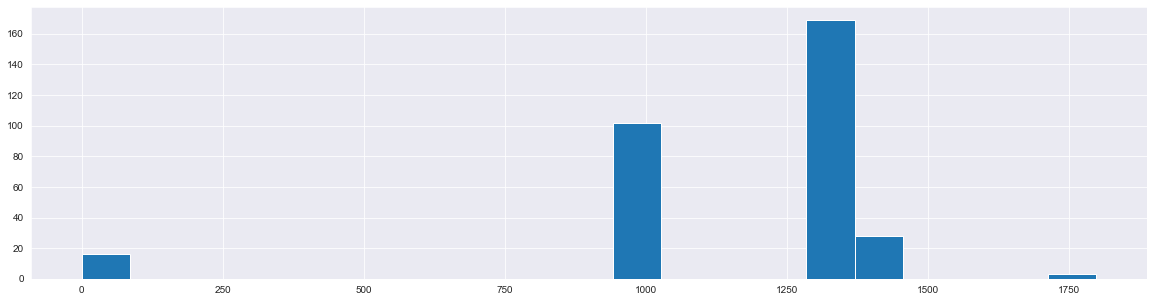

In [36]:
disp_counter = df['engine_capacity'].nunique()
df['engine_capacity'].hist(bins=disp_counter,figsize=(20,5))
plt.show()

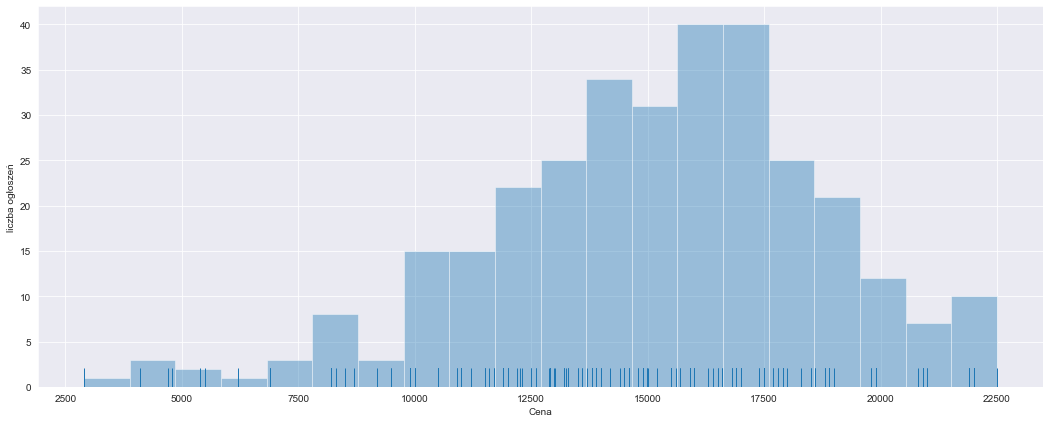

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,7))
chart = sns.distplot(df['price'], bins=20, kde=False, rug=True)
chart.set(xlabel='Cena', ylabel='liczba ogłoszeń');

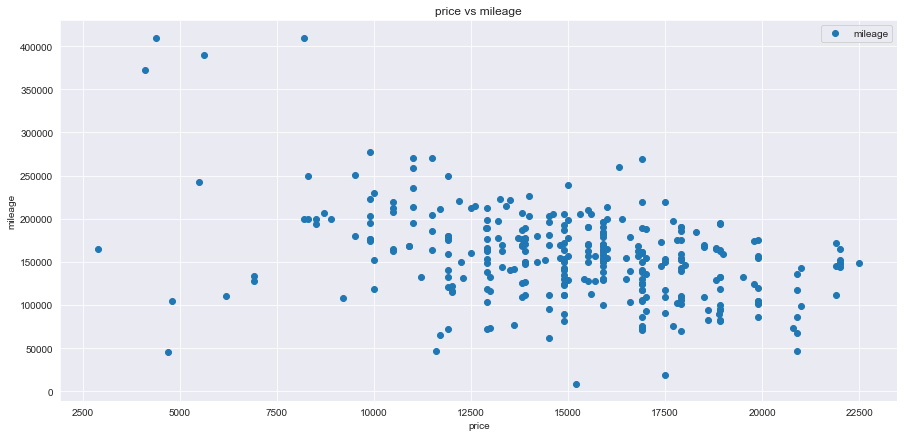

In [65]:

df.plot(x='price_raw', y='mileage', style='o', figsize=(15,7)) 
plt.title('price vs mileage')  
plt.xlabel('price')  
plt.ylabel('mileage')  
plt.show()

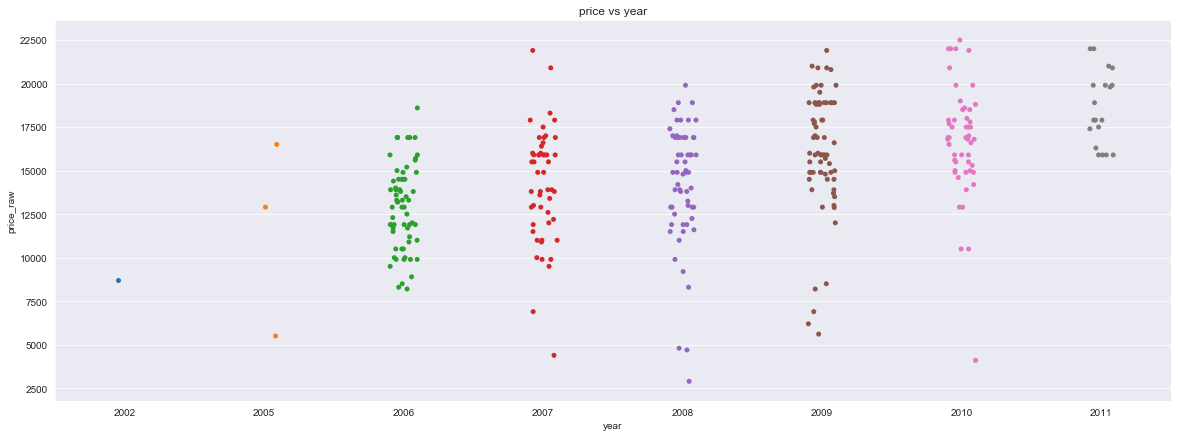

In [74]:
plt.figure(figsize=(20, 7))
plt.title('price vs year')  
plt.xlabel('year')  
plt.ylabel('price') 
sns.stripplot(x="year", y="price_raw", data=df);


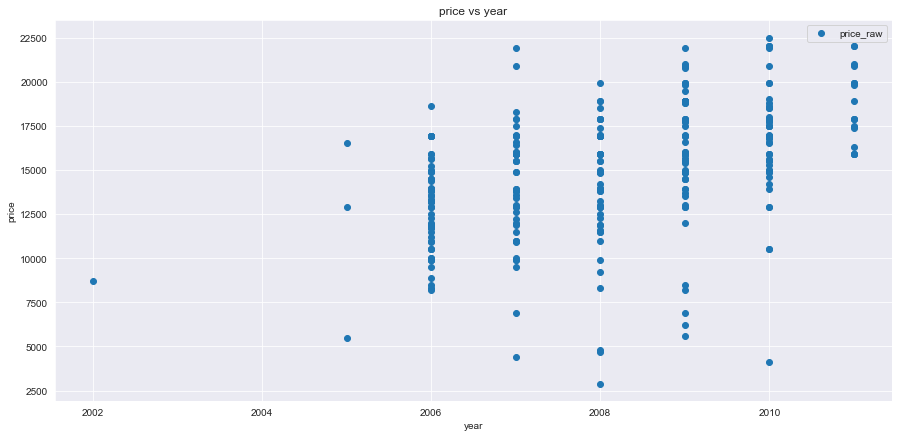

In [66]:
df.plot(x='year', y='price_raw', style='o', figsize=(15,7)) 
plt.title('price vs year')  
plt.xlabel('year')  
plt.ylabel('price')  
plt.show()

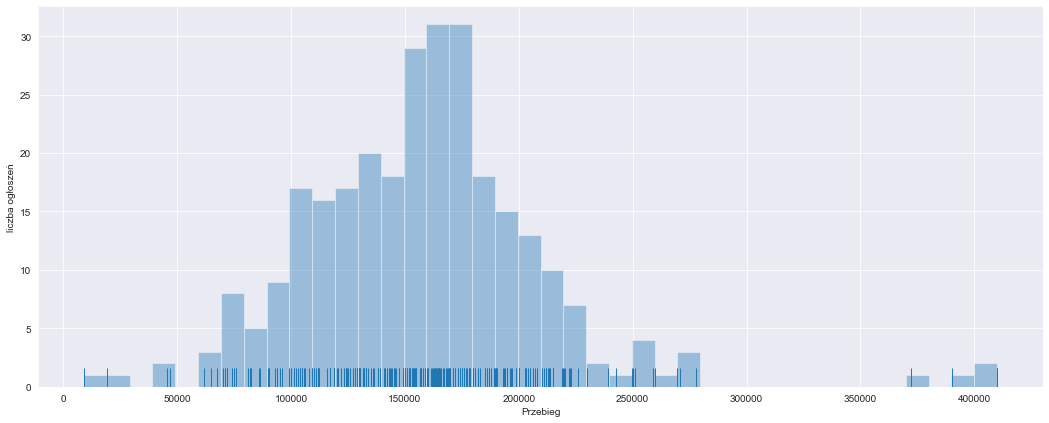

In [18]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,7))
chart = sns.distplot(df['mileage'], bins=40, kde=False, rug=True)
chart.set(xlabel='Przebieg', ylabel='liczba ogłoszeń');

### Czas trwania ogłoszenia

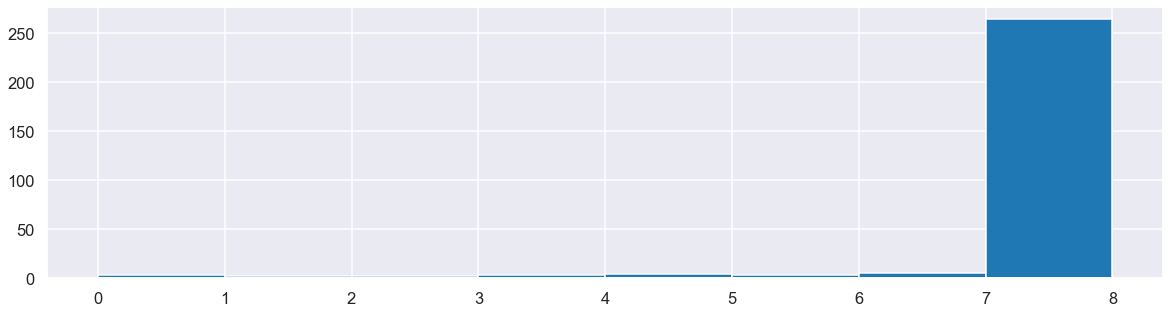

In [31]:
offer_duration = df['duration'].max()
df['duration'].hist(bins=offer_duration,figsize=(20,5))
plt.show()

### Cena końcowa

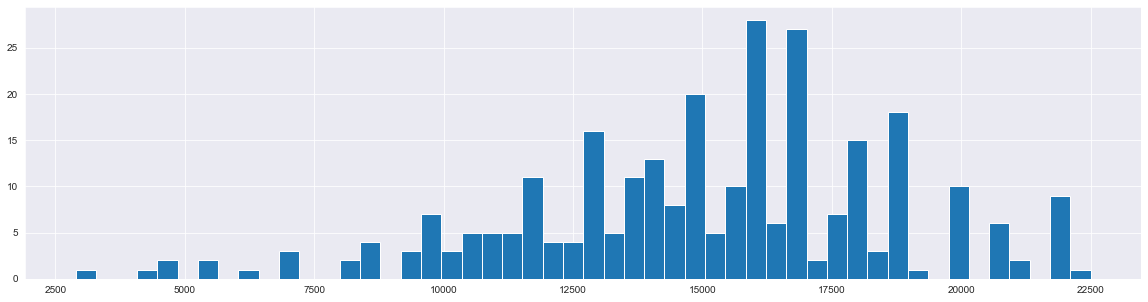

In [20]:
df['price'].hist(bins=50,figsize=(20,5))
plt.show()

In [21]:
filter_max = np.percentile(df['price'],99)
filter_max

21999.15

### Cena końcowa - 99 percentyl

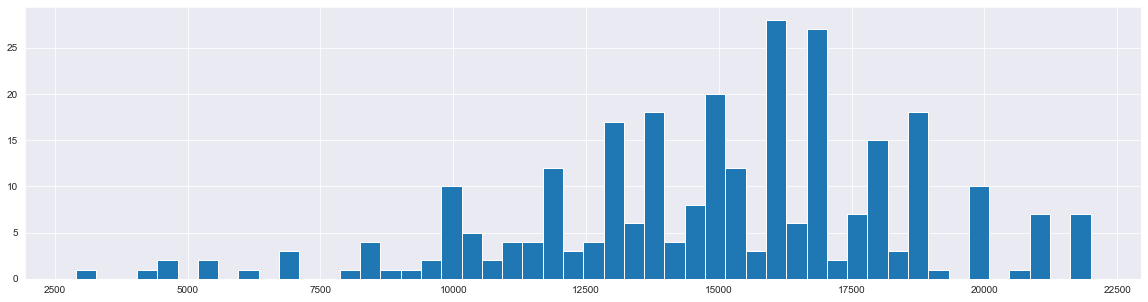

In [22]:
df_filter = df[df['price'] < filter_max]
df_filter['price'].hist(bins=50,figsize=(20,5))
plt.show()

### Przebieg

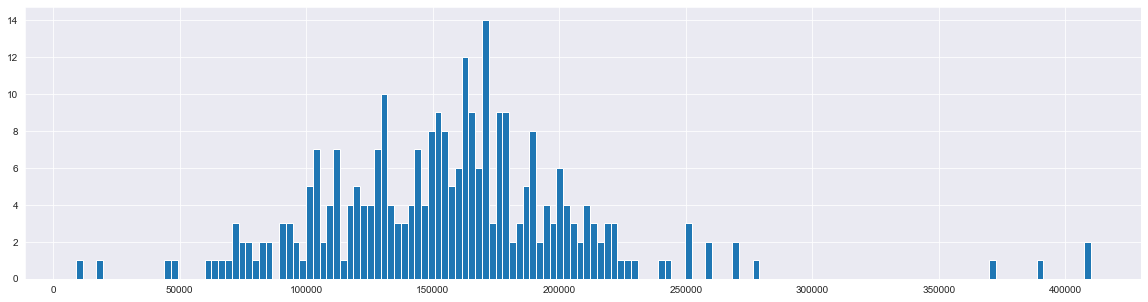

In [23]:
df['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

### Przebieg - 99 percentyl

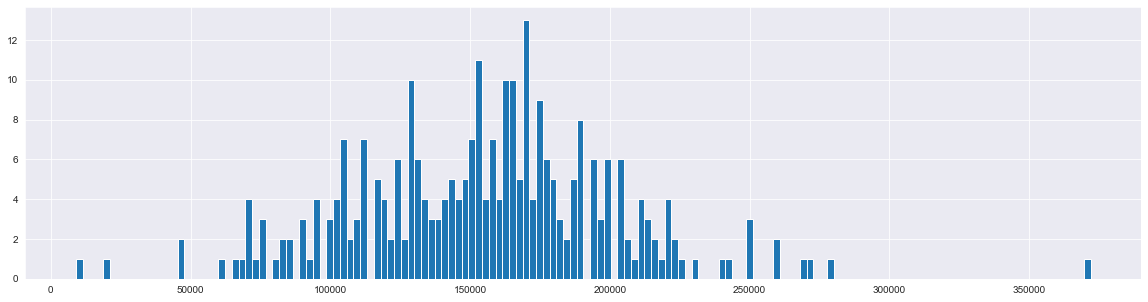

In [24]:
df_mileage = df[df['mileage'] < np.percentile(df['mileage'],99)]
df_mileage['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

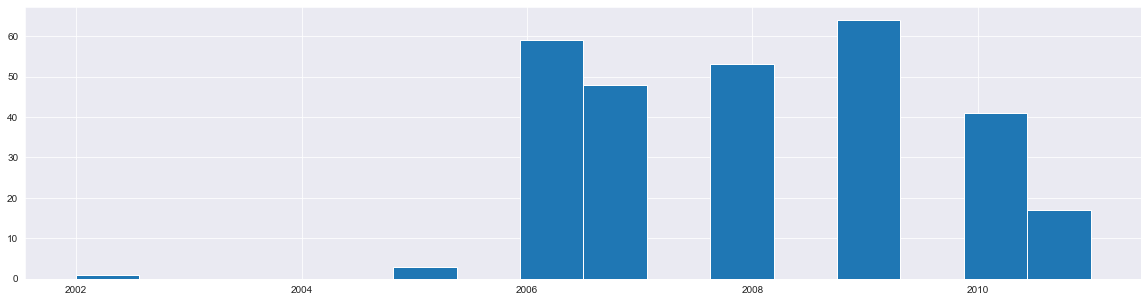

In [25]:
offer_year = df['year'].nunique()*2
df['year'].hist(bins=offer_year,figsize=(20,5))
plt.show()

In [26]:
#x=[2009,2010,2011]
#y=[200,300,400]
#df = pd.DataFrame(dict(x=x, y=y))

#print(type(df))

#ax = sns.barplot(x=x, y=y)

In [27]:
df[df['year'] == 2009 ].shape[0]

64

Wall time: 158 ms


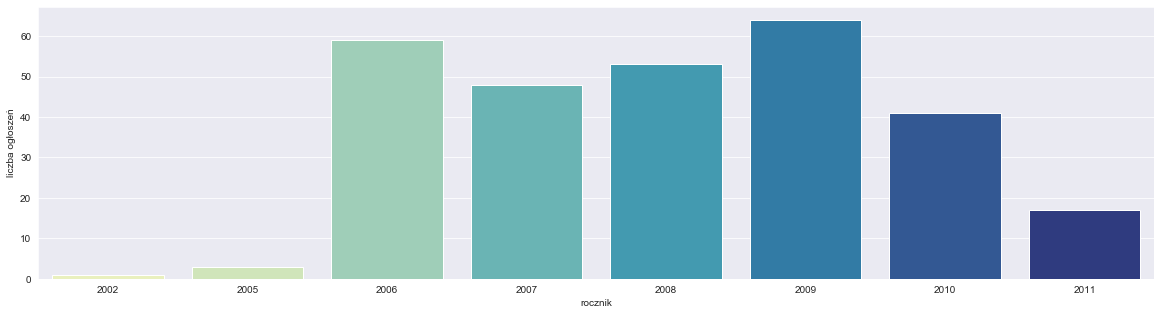

In [28]:
def plot_year():
    year_list = df['year'].unique()

    x = []
    y = []
    for i in year_list:
        x.append(i)
        y.append(df[df['year'] == i ].shape[0])
    
    sdf = pd.DataFrame(dict(x=x, y=y)).sort_values(by=['x'])

    sns.set_style("darkgrid")  
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=x, y=y, data=sdf, palette=("YlGnBu"))
    ax.set(xlabel='rocznik', ylabel='liczba ogłoszeń')
    sns.set_context("talk")
    plt.savefig('sns.png')
    
%time plot_year()


Wall time: 174 ms


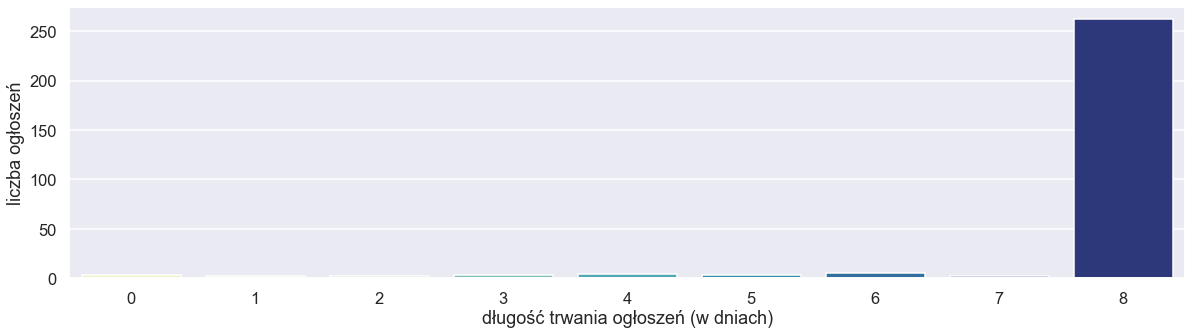

In [29]:
def plot_duration():
    year_list = df['duration'].unique()

    x = []
    y = []
    for i in year_list:
        x.append(i)
        y.append(df[df['duration'] == i ].shape[0])
    
    sdf = pd.DataFrame(dict(x=x, y=y)).sort_values(by=['x'])

    sns.set_style("darkgrid")  
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=x, y=y, data=sdf, palette=("YlGnBu"))
    ax.set(xlabel='długość trwania ogłoszeń (w dniach)', ylabel='liczba ogłoszeń')
    sns.set_context("talk")
    plt.savefig('sns_duration.png')
    
%time plot_duration()

## ML

In [31]:
np.random.seed(0)
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import scikitplot as skplt

xgb_params = {
    'max_depth' : 5, 
    'n_estimators' : 100, 
    'learning_rate' : 0.3, 
    'random_state' : 0
}

model = xgb.XGBRegressor(**xgb_params)

['year', 'mileage', 'engine_capacity', 'engine_power', 'door_count', 'nr_seats', 'duration', 'price_chng', 'f_0', 'f_system-start-stop', 'f_assisted-steering', 'f_tinted-windows', 'f_alloy-wheels', 'f_cd-changer', 'f_park-assist', 'f_velour-interior', 'f_central-lock', 'f_front-airbags', 'f_leds', 'f_automatic-wipers', 'f_electronic-rearview-mirrors', 'f_rear-passenger-airbags', 'f_head-display', 'f_heated-windshield', 'f_roof-bars', 'f_bluetooth', 'f_front-passenger-airbags', 'f_rear-electric-windows', 'f_front-heated-seats', 'f_fog-lights', 'f_onboard-computer', 'f_electronic-immobiliser', 'f_front-side-airbags', 'f_aux-in', 'f_mp3', 'f_electric-adjustable-seats', 'f_cd', 'f_electric-exterior-mirror', 'f_sd-socket', 'f_automatic-air-conditioning', 'f_side-window-airbags', 'f_heated-rearview-mirrors', 'f_rear-parking-sensors', 'f_gps', 'f_usb-socket', 'f_electric-interior-mirror', 'f_original-radio', 'f_air-conditioning', 'f_esp', 'f_daytime-lights', 'f_front-electric-windows', 'f_aut

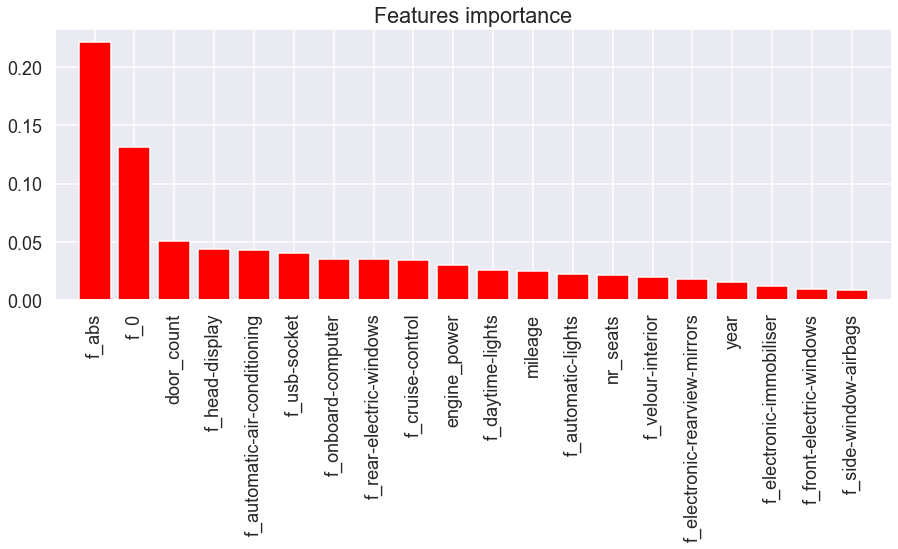

In [54]:
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['price', 'price_raw', 'offer_id']
    return [x for x in feats if x not in black_list]

def get_cat_feats(df):
    cat_feats = df.select_dtypes(include=[np.object]).columns
    black_list = ['features', 'model']
    cat_feats_list =  [x for x in cat_feats if x not in black_list]

    for cat_feat in cat_feats_list:
        df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

    
feats = get_feats(df)
print(feats)

X = df[feats].values
y = df['price'].values


def simple_split_model(model, X,y):
    #train and predict
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #print(confusion_matrix(y_test.astype(int), y_pred.astype(int)))
    #print(classification_report(y_test.astype(int), y_pred.astype(int)))   
    #print(mean_squared_error(y_test.astype(int), y_pred.astype(int)))
    
    skplt.estimators.plot_feature_importances(model, feature_names=feats, title='Features importance', x_tick_rotation=90, figsize=(15, 5));
    #skplt.estimators.plot_learning_curve(model, X_train, y_train,'Learning Curve',cv=5);
    #xgb.plot_importance(model.get_booster(), importance_type='gain')

%time simple_split_model(model, X, y)

In [43]:
df[feats].head(1)

,year,mileage,engine_capacity,engine_power,door_count,nr_seats,duration,price_chng,f_0,f_system-start-stop,...,f_driver-knee-airbag,f_alarm,f_cruise-control,f_towing-hook,f_steering-whell-comands,f_shift-paddles,f_isofix,f_dual-air-conditioning,f_abs,f_asr
0,2009,111000,1000,0,5,5,7,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
car_info = pd.DataFrame(columns = feats)
car_info = car_info.append({'year' : '2008' , 'mileage' : 145000, 'f_gps':0 } , ignore_index=True)
car_info

,year,mileage,engine_capacity,engine_power,door_count,nr_seats,duration,price_chng,f_0,f_system-start-stop,...,f_driver-knee-airbag,f_alarm,f_cruise-control,f_towing-hook,f_steering-whell-comands,f_shift-paddles,f_isofix,f_dual-air-conditioning,f_abs,f_asr
0,2008,145000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
y_pred = model.predict(car_info.values)
y_pred

array([15542.7295], dtype=float32)

In [37]:
print(X[0].shape)

(62,)


In [80]:
get_cat_feats(df)
feats = get_feats(df)
print(feats)

['year', 'mileage', 'engine_capacity', 'engine_power', 'door_count', 'nr_seats', 'duration', 'price_chng', 'f_onboard-computer', 'f_0', 'f_asr', 'f_esp', 'f_head-display', 'f_park-assist', 'f_roof-bars', 'f_bluetooth', 'f_daytime-lights', 'f_electric-interior-mirror', 'f_sd-socket', 'f_side-window-airbags', 'f_heated-rearview-mirrors', 'f_automatic-air-conditioning', 'f_aux-in', 'f_automatic-wipers', 'f_front-electric-windows', 'f_front-passenger-airbags', 'f_gps', 'f_front-heated-seats', 'f_isofix', 'f_central-lock', 'f_driver-knee-airbag', 'f_alarm', 'f_alloy-wheels', 'f_heated-windshield', 'f_electronic-rearview-mirrors', 'f_electronic-immobiliser', 'f_assisted-steering', 'f_leds', 'f_fog-lights', 'f_rear-electric-windows', 'f_shift-paddles', 'f_velour-interior', 'f_electric-adjustable-seats', 'f_cd-changer', 'f_mp3', 'f_front-airbags', 'f_rear-parking-sensors', 'f_cd', 'f_rear-passenger-airbags', 'f_steering-whell-comands', 'f_tinted-windows', 'f_system-start-stop', 'f_dual-air-con

In [74]:
df[df['f_usb-socket'] == 1]

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,f_driver-knee-airbag,f_alarm,f_cruise-control,f_towing-hook,f_steering-whell-comands,f_shift-paddles,f_isofix,f_dual-air-conditioning,f_abs,f_asr
14,6055607995,2020-04-23,2020-04-24,business,slaskie,zawiercie,yaris,2010,159500,1300,...,0,1,1,1,0,0,1,0,1,1
36,6061613472,2020-04-17,2020-04-22,business,opolskie,nysa,yaris,2010,166567,1300,...,0,1,0,0,0,0,1,0,1,1
57,6066265253,2020-04-17,2020-04-24,business,pomorskie,lebork,yaris,2010,146250,998,...,0,1,0,0,0,0,0,0,1,1
62,6066936383,2020-04-17,2020-04-24,private,pomorskie,koscierzyna,yaris,2009,213285,1329,...,0,0,0,0,0,0,1,0,1,1
69,6067468696,2020-04-17,2020-04-21,business,wielkopolskie,pila,yaris,2011,173453,1400,...,1,1,0,0,1,0,1,0,1,1
85,6068055441,2020-04-22,2020-04-24,business,wielkopolskie,pleszew,yaris,2010,162641,1400,...,0,1,1,0,1,0,1,0,1,0
141,6069777341,2020-04-17,2020-04-24,business,dolnoslaskie,zabkowice-slaskie,yaris,2008,119000,998,...,1,0,0,0,1,0,1,0,1,0
165,6070704518,2020-04-17,2020-04-24,private,swietokrzyskie,staszow,yaris,2002,206261,1400,...,1,1,0,0,1,0,1,0,1,1
171,6070774728,2020-04-17,2020-04-24,business,malopolskie,krakow,yaris,2008,165000,1296,...,0,0,0,0,1,0,1,0,1,0
173,6070820213,2020-04-17,2020-04-24,private,mazowieckie,zyrardow,yaris,2011,67522,1329,...,1,1,0,0,1,0,1,0,1,1
